In [1]:
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

# 1. LOAD OPTIMIZATION RESULTS

In [2]:
# Define input files
input_files = {
    'GHG1': './input/mekong_2020_288h_4_years_AD110dams_GHG1.xlsx',
    'GHG2': './input/mekong_2020_288h_4_years_AD110dams_GHG2.xlsx',
    'GHG3': './input/mekong_2020_288h_4_years_AD110dams_GHG3.xlsx',
    'GHG4': './input/mekong_2020_288h_4_years_AD110dams_GHG4.xlsx'
}

# Initialize dictionaries for results storage
cost_data = {}
sediment_data = {}

# Process each GHG scenario
for ghg, file_path in input_files.items():
    # Generate output file paths
    output_paths = [f"LP-limit{i}-GHG{j}-sequence" for i in [1,2,4,6] for j in [1,2,3,4]]
    
    # Process each output file
    for path in output_paths:
        output_dir = f'./output/{path}/'
        if not os.path.exists(output_dir):
            continue
            
        for file in os.listdir(output_dir):
            # Extract scenario parameters from filename
            parts = file.split('_')
            ghg_limit = parts[-3]
            trans_limit = parts[-2]
            number = int(parts[-1].split('.')[0])
            
            # Load dataset
            ds = xr.open_dataset(os.path.join(output_dir, file))
            
            # Store results
            key = (ghg_limit, trans_limit, number)
            sediment_data[key] = ds.sediment_v.item()
            cost_data[key] = ds.cost_v.item() / 1e9  # Convert to billions

# 2. PROCESS UNCERTAINTY RESULTS

In [6]:
# Load uncertainty data
uncertainty_data = np.load('./output/uncertainty_results.npz', allow_pickle=True)
sediment_uncertainty = uncertainty_data['sediment_list'].item()
cost_uncertainty = uncertainty_data['cost_list'].item()  # This is the correct name

# Load scenario comparison data
scenario_df = pd.read_excel("./output/uncertainty_all_scenarios.xlsx")
matching_columns = ["demand", "fuel price", "inflow", 
                    "technology upper bound", "technology fix cost", "transline fix cost"]

# ... [rest of the code] ...

# Calculate cost differences
cost_differences = {}

for base_sol, comp_sol in solution_pairs:
    # Filter matching scenarios
    base_df = scenario_df[
        (scenario_df["carbon"] == base_sol) & 
        (scenario_df['discount factor'] == 'discount factor medium.xlsx')
    ].copy()
    comp_df = scenario_df[
        (scenario_df["carbon"] == comp_sol) & 
        (scenario_df['discount factor'] == 'discount factor medium.xlsx')
    ].copy()
    
    # Create merge keys
    base_df['merge_key'] = base_df[matching_columns].apply(tuple, axis=1)
    comp_df['merge_key'] = comp_df[matching_columns].apply(tuple, axis=1)
    
    # Preserve original indices
    base_df['original_index'] = base_df.index
    comp_df['original_index'] = comp_df.index
    
    # Find matching pairs
    matches = pd.merge(base_df, comp_df, on='merge_key', suffixes=('_base', '_comp'))
    
    # Skip if no matches
    if len(matches) == 0:
        print(f"No matches found for pair: ({base_sol}, {comp_sol})")
        cost_differences[(base_sol, comp_sol)] = {}
        continue
        
    # Get matching indices
    matching_indices = list(zip(matches['original_index_base'], matches['original_index_comp']))
    
    # Calculate cost differences
    diffs = {}
    for idx_base, idx_comp in matching_indices:
        base_file = f"mekong_2020_288h_4_years_AD110dams__{idx_base}.nc"
        comp_file = f"mekong_2020_288h_4_years_AD110dams__{idx_comp}.nc"
        
        # Use the correct variable name: cost_uncertainty
        base_cost = cost_uncertainty.get(base_sol, {}).get(base_file, 0)
        comp_cost = cost_uncertainty.get(comp_sol, {}).get(comp_file, 0)
        diffs[(idx_base, idx_comp)] = base_cost - comp_cost
    
    cost_differences[(base_sol, comp_sol)] = diffs

In [6]:
# Calculate mean sediment values for each scenario
for ghg in ghg_scenarios:
    for limit in limit_scenarios:
        Quo_Sed[(ghg, limit)] = sediment_list['solution_S0_2.xlsx'].mean()
        All_Sed[(ghg, limit)] = sediment_list['solution_F0_2.xlsx'].mean()
        
        # Assign appropriate low-impact sediment scenario
        if limit == 'limit1':
            Low_impact_Sed[(ghg, limit)] = sediment_list['solution_L2.xlsx'].mean()
        elif limit == 'limit2':
            Low_impact_Sed[(ghg, limit)] = sediment_list['solution_L3.xlsx'].mean()
        elif limit == 'limit4':
            Low_impact_Sed[(ghg, limit)] = sediment_list['solution_L4_2.xlsx'].mean()
        else:
            if ghg == "GHG1":
                Low_impact_Sed[(ghg, limit)] = sediment_list['solution_L1_2.xlsx'].mean()
            elif ghg == "GHG2":
                Low_impact_Sed[(ghg, limit)] = sediment_list['solution_L6_2.xlsx'].mean()
            else:
                Low_impact_Sed[(ghg, limit)] = sediment_list['solution_L5_2.xlsx'].mean()

# 3. PREPARE PLOTTING DATA 

In [7]:
# Define scenario mappings
limit_scenarios = ['limit1', 'limit2', 'limit4', 'limit6']
ghg_scenarios = ['GHG1', 'GHG2', 'GHG3', 'GHG4']

# Mapping dictionaries
scenario_mappings = {
    'low_impact': {
        ('GHG1','limit1'): ('solution_S2.xlsx', 'solution_L2.xlsx'),
        ('GHG1','limit2'): ('solution_S3.xlsx', 'solution_L3.xlsx'),
        ('GHG1','limit4'): ('solution_S4.xlsx', 'solution_L4_2.xlsx'),
        ('GHG1','limit6'): ('solution_S0_2.xlsx', 'solution_L1_2.xlsx'),
        ('GHG2','limit1'): ('solution_S7.xlsx', 'solution_L7.xlsx'),
        ('GHG2','limit2'): ('solution_S8.xlsx', 'solution_L8.xlsx'),
        ('GHG2','limit4'): ('solution_S9.xlsx', 'solution_L9.xlsx'),
        ('GHG2','limit6'): ('solution_S6.xlsx', 'solution_L6_2.xlsx'),
        ('GHG3','limit1'): ('solution_S10.xlsx', 'solution_L10.xlsx'),
        ('GHG3','limit2'): ('solution_S11.xlsx', 'solution_L11.xlsx'),
        ('GHG3','limit4'): ('solution_S12.xlsx', 'solution_L12.xlsx'),
        ('GHG3','limit6'): ('solution_S5.xlsx', 'solution_L5_2.xlsx'),
        ('GHG4','limit1'): ('solution_S13.xlsx', 'solution_L13.xlsx'),
        ('GHG4','limit2'): ('solution_S14.xlsx', 'solution_L14.xlsx'),
        ('GHG4','limit4'): ('solution_S15.xlsx', 'solution_L15.xlsx'),
        ('GHG4','limit6'): ('solution_S16.xlsx', 'solution_L16.xlsx'),
    },
    'high_impact': {
        ('GHG1','limit1'): ('solution_S2.xlsx', 'solution_F2.xlsx'),
        ('GHG1','limit2'): ('solution_S3.xlsx', 'solution_F3.xlsx'),
        ('GHG1','limit4'): ('solution_S4.xlsx', 'solution_F4.xlsx'),
        ('GHG1','limit6'): ('solution_S0_2.xlsx', 'solution_F0_2.xlsx'),
        ('GHG2','limit1'): ('solution_S7.xlsx', 'solution_F7.xlsx'),
        ('GHG2','limit2'): ('solution_S8.xlsx', 'solution_F8.xlsx'),
        ('GHG2','limit4'): ('solution_S9.xlsx', 'solution_F9.xlsx'),
        ('GHG2','limit6'): ('solution_S6.xlsx', 'solution_F6.xlsx'),
        ('GHG3','limit1'): ('solution_S10.xlsx', 'solution_F10.xlsx'),
        ('GHG3','limit2'): ('solution_S11.xlsx', 'solution_F11.xlsx'),
        ('GHG3','limit4'): ('solution_S12.xlsx', 'solution_F12.xlsx'),
        ('GHG3','limit6'): ('solution_S5.xlsx', 'solution_F5.xlsx'),
        ('GHG4','limit1'): ('solution_S13.xlsx', 'solution_F13.xlsx'),
        ('GHG4','limit2'): ('solution_S14.xlsx', 'solution_F14.xlsx'),
        ('GHG4','limit4'): ('solution_S15.xlsx', 'solution_F15.xlsx'),
        ('GHG4','limit6'): ('solution_S16.xlsx', 'solution_F16.xlsx'),
    }
}

# Initialize result dictionaries
cost_below_threshold = {}
sediment_below_threshold = {}
low_impact_savings = {}
all_savings = {}
low_impact_sediment = {}
all_sediment = {}
status_quo_sediment = {}

# Sediment threshold
SEDIMENT_THRESHOLD = 51

# Prepare sediment data from Excel
sediment_df = pd.read_excel("./output/uncertainty_analysis_8experiments.xlsx", 
                           sheet_name="Sediment Flux")
sediment_values = {
    'solution_L1_2.xlsx': sediment_df["[1, 6, 27]"].dropna().values,
    'solution_F0_2.xlsx': sediment_df["[1, 6, 48]"].dropna().values,
    'solution_S0_2.xlsx': sediment_df["[1, 6, 0]"].dropna().values,
    'solution_L2.xlsx': sediment_df["[1, 1, 27]"].dropna().values,
    'solution_L3.xlsx': sediment_df["[1, 2, 27]"].dropna().values,
    'solution_L4_2.xlsx': sediment_df["[1, 4, 27]"].dropna().values,
    'solution_L5_2.xlsx': sediment_df["[3, 6, 27]"].dropna().values,
    'solution_L6_2.xlsx': sediment_df["[2, 6, 27]"].dropna().values
}

# Process each scenario combination
for ghg in ghg_scenarios:
    for limit in limit_scenarios:
        # Initialize storage for below-threshold values
        cost_below = []
        sediment_below = []
        
        # Process each solution number (0-48)
        for sol_num in range(49):
            key = (ghg, limit, sol_num)
            
            if sol_num == 0:
                cost_saving_val = 0
            else:
                # Calculate cost savings relative to high-impact scenario
                base_key = scenario_mappings['high_impact'][(ghg, limit)][0]
                base_cost = np.mean(list(cost_uncertainty.get(base_key, {}).values()))
                cost_saving_val = base_cost - cost_data[key]
            
            # Apply sediment threshold filter
            if sediment_data[key] < SEDIMENT_THRESHOLD:
                cost_below.append(cost_saving_val)
                sediment_below.append(sediment_data[key])
        
        # Store below-threshold values
        cost_below_threshold[(ghg, limit)] = cost_below
        sediment_below_threshold[(ghg, limit)] = sediment_below
        
        # Store savings values
        low_impact_savings[(ghg, limit)] = cost_differences.get(
            scenario_mappings['low_impact'][(ghg, limit)], {}
        )
        all_savings[(ghg, limit)] = cost_differences.get(
            scenario_mappings['high_impact'][(ghg, limit)], {}
        )
        
        # Calculate mean sediment values
        status_quo_sediment[(ghg, limit)] = sediment_values['solution_S0_2.xlsx'].mean()
        all_sediment[(ghg, limit)] = sediment_values['solution_F0_2.xlsx'].mean()
        
        # Assign appropriate low-impact sediment scenario
        if limit == 'limit1':
            low_impact_sediment[(ghg, limit)] = sediment_values['solution_L2.xlsx'].mean()
        elif limit == 'limit2':
            low_impact_sediment[(ghg, limit)] = sediment_values['solution_L3.xlsx'].mean()
        elif limit == 'limit4':
            low_impact_sediment[(ghg, limit)] = sediment_values['solution_L4_2.xlsx'].mean()
        else:
            if ghg == "GHG1":
                low_impact_sediment[(ghg, limit)] = sediment_values['solution_L1_2.xlsx'].mean()
            elif ghg == "GHG2":
                low_impact_sediment[(ghg, limit)] = sediment_values['solution_L6_2.xlsx'].mean()
            else:
                low_impact_sediment[(ghg, limit)] = sediment_values['solution_L5_2.xlsx'].mean()

# 4. PLOT RESULTS

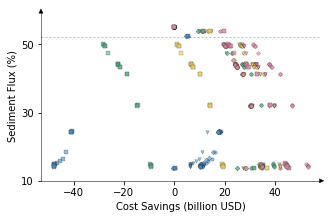

In [10]:
%matplotlib inline 
# Create figure
fig, ax = plt.subplots(figsize=(120/25.4, 80/25.4))

# Define visual properties
markers = {'GHG1': 's', 'GHG2': 'o', 'GHG3': "v", 'GHG4': 'D'}
colors = {'limit1': '#4A8CC3', 'limit2': '#53AC82', 'limit4': '#EDCD5E', 'limit6': '#DF85A4'}

# Plot data points
for ghg in ghg_scenarios:
    for limit in limit_scenarios:
        # Get z-order for visual layering
        zorder = 3 if ghg == 'GHG1' else 2
        
        # Plot main scenario points
        ax.scatter(
            np.mean(list(low_impact_savings[(ghg, limit)].values())) if low_impact_savings[(ghg, limit)] else 0, 
            low_impact_sediment[(ghg, limit)],
            s=12, edgecolors='black', facecolor=colors[limit], linewidth=0.25,
            marker=markers[ghg], zorder=zorder, alpha=0.8
        )

        ax.scatter(
            np.mean(list(all_savings[(ghg, limit)].values())) if all_savings[(ghg, limit)] else 0, 
            all_sediment[(ghg, limit)],
            s=12, edgecolors='black', facecolor=colors[limit], linewidth=0.25,
            marker=markers[ghg], zorder=zorder, alpha=0.8
        )
        # Plot below-threshold points
        ax.scatter(
            cost_below_threshold[(ghg, limit)], 
            sediment_below_threshold[(ghg, limit)],
            s=12, edgecolors='black', facecolor=colors[limit], linewidth=0.25,
            marker=markers[ghg], zorder=zorder, alpha=0.6
        )
        
        # Plot status quo point
        ax.scatter(
            0, 
            status_quo_sediment[(ghg, limit)],
            s=12, edgecolors='black', facecolor=colors[limit], linewidth=0.25,
            marker=markers[ghg], zorder=zorder, alpha=0.8
        )

# Configure plot aesthetics
ax.set_ylim(10, 60)
ax.axhline(y=54.8 * 0.95, color='grey', linewidth=0.5, linestyle='--', dashes=(4, 4))
ax.set_yticks([10, 30, 50])
ax.set_xlabel('Cost Savings (billion USD)')
ax.set_ylabel('Sediment Flux (%)')

# Clean up plot borders
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)
for spine in ['left', 'bottom']:
    ax.spines[spine].set_color('black')
    ax.spines[spine].set_linewidth(0.5)

# Add directional arrows
arrow_props = dict(arrowstyle="<|-", color='black', linewidth=0.5)
ax.annotate('', xy=(1, 0), xycoords='axes fraction', xytext=(1.02, 0),
            arrowprops=arrow_props)
ax.annotate('', xy=(0, 1), xycoords='axes fraction', xytext=(0, 1.02),
            arrowprops=arrow_props)

# Save and show plot
plt.tight_layout()
plt.savefig('Fig_3A.pdf', dpi=300)

# Processing output files:

# 读取数据

In [5]:
data = np.load('./output/uncertainty_results.npz', allow_pickle=True)
sediment_list = data['sediment_list'].item()
cost_list = data['cost_list'].item()
install_list= data['install_list'].item()
install_list

{'solution_F0_1.xlsx': {('mekong_2020_288h_4_years_AD110dams__10260.nc',
   'Bioenergy'): 22.54794520547945,
  ('mekong_2020_288h_4_years_AD110dams__10260.nc', 'Coal'): 0.0,
  ('mekong_2020_288h_4_years_AD110dams__10260.nc', 'Gas'): 12.395199256911232,
  ('mekong_2020_288h_4_years_AD110dams__10260.nc', 'Hydro'): 26.7518,
  ('mekong_2020_288h_4_years_AD110dams__10260.nc',
   'Li-ion'): 172.2217073612368,
  ('mekong_2020_288h_4_years_AD110dams__10260.nc', 'Oil'): 0.0,
  ('mekong_2020_288h_4_years_AD110dams__10260.nc', 'Solar'): 536.8993112040546,
  ('mekong_2020_288h_4_years_AD110dams__10260.nc', 'Wind'): 269.5744459861161,
  ('mekong_2020_288h_4_years_AD110dams__10261.nc',
   'Bioenergy'): 22.54794520547945,
  ('mekong_2020_288h_4_years_AD110dams__10261.nc', 'Coal'): 0.0,
  ('mekong_2020_288h_4_years_AD110dams__10261.nc', 'Gas'): 12.378972923664637,
  ('mekong_2020_288h_4_years_AD110dams__10261.nc', 'Hydro'): 26.7518,
  ('mekong_2020_288h_4_years_AD110dams__10261.nc',
   'Li-ion'): 172.

In [6]:
#calculate the difference   

import pandas as pd

target_values = [
    ('solution_S0_2.xlsx', 'solution_L1_2.xlsx'),
    ('solution_S0_2.xlsx', 'solution_F0_2.xlsx'),
    ('solution_S2.xlsx', 'solution_L2.xlsx'),
    ('solution_S3.xlsx', 'solution_L3.xlsx'),
    ('solution_S4.xlsx', 'solution_L4_2.xlsx'),
    ('solution_S5.xlsx', 'solution_L5_2.xlsx'),
    ('solution_S6.xlsx', 'solution_L6_2.xlsx'),
    ('solution_S2.xlsx', 'solution_F2.xlsx'),
    ('solution_S3.xlsx', 'solution_F3.xlsx'),
    ('solution_S4.xlsx', 'solution_F4.xlsx'),
    ('solution_S5.xlsx', 'solution_F5.xlsx'),
    ('solution_S6.xlsx', 'solution_F6.xlsx'),
    ('solution_S7.xlsx', 'solution_F7.xlsx'),
    ('solution_S7.xlsx', 'solution_L7.xlsx'),
    ('solution_S8.xlsx', 'solution_F8.xlsx'),
    ('solution_S8.xlsx', 'solution_L8.xlsx'),
    ('solution_S9.xlsx', 'solution_F9.xlsx'),
    ('solution_S9.xlsx', 'solution_L9.xlsx'),
    ('solution_S10.xlsx', 'solution_F10.xlsx'),
    ('solution_S10.xlsx', 'solution_L10.xlsx'),
    ('solution_S11.xlsx', 'solution_F11.xlsx'),
    ('solution_S11.xlsx', 'solution_L11.xlsx'),
    ('solution_S12.xlsx', 'solution_F12.xlsx'),
    ('solution_S12.xlsx', 'solution_L12.xlsx'),
    ('solution_S13.xlsx', 'solution_F13.xlsx'),
    ('solution_S13.xlsx', 'solution_L13.xlsx'),
    ('solution_S14.xlsx', 'solution_F14.xlsx'),
    ('solution_S14.xlsx', 'solution_L14.xlsx'),
    ('solution_S15.xlsx', 'solution_F15.xlsx'),
    ('solution_S15.xlsx', 'solution_L15.xlsx'),
    ('solution_S16.xlsx', 'solution_F16.xlsx'),
    ('solution_S16.xlsx', 'solution_L16.xlsx')
]


# Load the dataset
df = pd.read_excel("./output/uncertainty_all_scenarios.xlsx")  # Update with actual file path if needed
# Define the columns to check for matching values
matching_columns = ["demand",  "fuel price", "inflow", 
                        "technology upper bound", "technology fix cost", "transline fix cost"]

def find_difference(solution_pair):
    print(solution_pair)
    base_solution  = solution_pair[0]
    develop_solution = solution_pair[1]
    df_1 = df[(df["carbon"] == base_solution) & (df['discount factor'] == 'discount factor medium.xlsx')].copy()
    df_2 = df[(df["carbon"] == develop_solution) & (df['discount factor'] == 'discount factor medium.xlsx')].copy()
    # Store indices before merging
    df_1["index_1"] = df_1.index
    df_2["index_2"] = df_2.index

    # Perform an inner merge on the selected columns to find matching tuples
    matched_pairs = df_1.merge(df_2, on=matching_columns, suffixes=("_1", "_2"))

    # Extract the index pairs
    matching_indices = list(zip(matched_pairs["index_1"], matched_pairs["index_2"]))


    # Print or use the results
    print(f"Number of matched pairs: {len(matching_indices)}")
    
    
    # Calculate cost differences (absolute and relative) for each pair
    cost_differences = {}
    relative_cost_differences = {}
    # Calculate cost differences for each pair
    
    for pair in matching_indices:
        file_1 = f"mekong_2020_288h_4_years_AD110dams__{pair[0]}.nc"
        file_2 = f"mekong_2020_288h_4_years_AD110dams__{pair[1]}.nc"

        # Absolute difference
        abs_diff = cost_list[base_solution][file_1] - cost_list[develop_solution][file_2]
        cost_differences[(pair[0], pair[1])] = abs_diff

        # Relative difference (percentage)
        base_value = cost_list[base_solution][file_1]  # Using L1_2 as the base for percentage
        if base_value != 0:
            rel_diff = (abs_diff / base_value) * 100  # Convert to percentage
        else:
            rel_diff = None  # Avoid division by zero

        relative_cost_differences[(pair[0], pair[1])] = rel_diff
        
    return cost_differences, relative_cost_differences
    


cost_dif_list={}
relative_cost_dif = {} 
    
    
for target_value in target_values:
    cost_diff, relative_diff = find_difference(target_value)
    cost_dif_list[target_value] = cost_diff
    relative_cost_dif[target_value] = relative_diff

('solution_S0_2.xlsx', 'solution_L1_2.xlsx')
Number of matched pairs: 729
('solution_S0_2.xlsx', 'solution_F0_2.xlsx')
Number of matched pairs: 729
('solution_S2.xlsx', 'solution_L2.xlsx')
Number of matched pairs: 729
('solution_S3.xlsx', 'solution_L3.xlsx')
Number of matched pairs: 729
('solution_S4.xlsx', 'solution_L4_2.xlsx')
Number of matched pairs: 729
('solution_S5.xlsx', 'solution_L5_2.xlsx')
Number of matched pairs: 729
('solution_S6.xlsx', 'solution_L6_2.xlsx')
Number of matched pairs: 729
('solution_S2.xlsx', 'solution_F2.xlsx')
Number of matched pairs: 729
('solution_S3.xlsx', 'solution_F3.xlsx')
Number of matched pairs: 729
('solution_S4.xlsx', 'solution_F4.xlsx')
Number of matched pairs: 729
('solution_S5.xlsx', 'solution_F5.xlsx')
Number of matched pairs: 729
('solution_S6.xlsx', 'solution_F6.xlsx')
Number of matched pairs: 729
('solution_S7.xlsx', 'solution_F7.xlsx')
Number of matched pairs: 729
('solution_S7.xlsx', 'solution_L7.xlsx')
Number of matched pairs: 729
('solu

In [7]:
#calculate the cost saving due to dam expansion

#define the variable dict cost_saving
cost_saving = {}
Low_impact_savings = {}
All_savings={}
Low_impact_Sed={}
All_Sed={}
Sed_threshold = 51
# Define dictionaries to store values in cost_LP and sediment_out_LP
cost_lp_below_threshold = {}
sediment_out_lp_below_threshold = {}

#Setting up scenarios and labels:
limit_Scenario=['limit1','limit2','limit4','limit6']
GHG_scenario= ['GHG1','GHG2','GHG3','GHG4']

pari_index_low = {('GHG1','limit1'):('solution_S2.xlsx', 'solution_L2.xlsx'),
                 ('GHG1','limit2'):('solution_S3.xlsx', 'solution_L3.xlsx'),
                 ('GHG1','limit4'):('solution_S4.xlsx', 'solution_L4_2.xlsx'),
                 ('GHG1','limit6'):('solution_S0_2.xlsx', 'solution_L1_2.xlsx'),
                 ('GHG2','limit1'):('solution_S7.xlsx', 'solution_L7.xlsx'),
                 ('GHG2','limit2'):('solution_S8.xlsx', 'solution_L8.xlsx'),
                 ('GHG2','limit4'):('solution_S9.xlsx', 'solution_L9.xlsx'),
                 ('GHG2','limit6'):('solution_S6.xlsx', 'solution_L6_2.xlsx'),
                 ('GHG3','limit1'):('solution_S10.xlsx', 'solution_L10.xlsx'),
                 ('GHG3','limit2'):('solution_S11.xlsx', 'solution_L11.xlsx'),
                 ('GHG3','limit4'):('solution_S12.xlsx', 'solution_L12.xlsx'),
                 ('GHG3','limit6'):('solution_S5.xlsx', 'solution_L5_2.xlsx'),
                 ('GHG4','limit1'):('solution_S13.xlsx', 'solution_L13.xlsx'),
                 ('GHG4','limit2'):('solution_S14.xlsx', 'solution_L14.xlsx'),
                 ('GHG4','limit4'):('solution_S15.xlsx', 'solution_L15.xlsx'),
                 ('GHG4','limit6'):('solution_S16.xlsx', 'solution_L16.xlsx'),
                 }
pari_index_high = {('GHG1','limit1'):('solution_S2.xlsx', 'solution_F2.xlsx'),
                 ('GHG1','limit2'):('solution_S3.xlsx', 'solution_F3.xlsx'),
                 ('GHG1','limit4'):('solution_S4.xlsx', 'solution_F4.xlsx'),
                 ('GHG1','limit6'):('solution_S0_2.xlsx', 'solution_F0_2.xlsx'),
                 ('GHG2','limit1'):('solution_S7.xlsx', 'solution_F7.xlsx'),
                 ('GHG2','limit2'):('solution_S8.xlsx', 'solution_F8.xlsx'),
                 ('GHG2','limit4'):('solution_S9.xlsx', 'solution_F9.xlsx'),
                 ('GHG2','limit6'):('solution_S6.xlsx', 'solution_F6.xlsx'),
                 ('GHG3','limit1'):('solution_S10.xlsx', 'solution_F10.xlsx'),
                 ('GHG3','limit2'):('solution_S11.xlsx', 'solution_F11.xlsx'),
                 ('GHG3','limit4'):('solution_S12.xlsx', 'solution_F12.xlsx'),
                 ('GHG3','limit6'):('solution_S5.xlsx', 'solution_F5.xlsx'),
                 ('GHG4','limit1'):('solution_S13.xlsx', 'solution_F13.xlsx'),
                 ('GHG4','limit2'):('solution_S14.xlsx', 'solution_F14.xlsx'),
                 ('GHG4','limit4'):('solution_S15.xlsx', 'solution_F15.xlsx'),
                 ('GHG4','limit6'):('solution_S16.xlsx', 'solution_F16.xlsx'),
                 }
pari_index_sediment_low = {('GHG1','limit1'): 'solution_L2.xlsx',
                 ('GHG1','limit2'): 'solution_L3.xlsx',
                 ('GHG1','limit4'):'solution_L4_2.xlsx',
                 ('GHG1','limit6'): 'solution_L1_2.xlsx',
                 ('GHG2','limit1'): 'solution_L7.xlsx',
                 ('GHG2','limit2'): 'solution_L8.xlsx',
                 ('GHG2','limit4'):'solution_L9.xlsx',
                 ('GHG2','limit6'): 'solution_L6_2.xlsx',
                 ('GHG3','limit1'):'solution_L10.xlsx',
                 ('GHG3','limit2'): 'solution_L11.xlsx',
                 ('GHG3','limit4'): 'solution_L12.xlsx',
                 ('GHG3','limit6'): 'solution_L5_2.xlsx',
                 ('GHG4','limit1'): 'solution_L13.xlsx',
                 ('GHG4','limit2'): 'solution_L14.xlsx',
                 ('GHG4','limit4'): 'solution_L15.xlsx',
                 ('GHG4','limit6'): 'solution_L16.xlsx',
                 }
pari_index_sediment_high = {('GHG1','limit1'):'solution_F2.xlsx',
                 ('GHG1','limit2'):'solution_F3.xlsx',
                 ('GHG1','limit4'): 'solution_F4.xlsx',
                 ('GHG1','limit6'): 'solution_F0_2.xlsx',
                 ('GHG2','limit1'): 'solution_F7.xlsx',
                 ('GHG2','limit2'): 'solution_F8.xlsx',
                 ('GHG2','limit4'): 'solution_F9.xlsx',
                 ('GHG2','limit6'): 'solution_F6.xlsx',
                 ('GHG3','limit1'): 'solution_F10.xlsx',
                 ('GHG3','limit2'): 'solution_F11.xlsx',
                 ('GHG3','limit4'): 'solution_F12.xlsx',
                 ('GHG3','limit6'): 'solution_F5.xlsx',
                 ('GHG4','limit1'): 'solution_F13.xlsx',
                 ('GHG4','limit2'): 'solution_F14.xlsx',
                 ('GHG4','limit4'): 'solution_F15.xlsx',
                 ('GHG4','limit6'): 'solution_F16.xlsx',
                 }

pari_index_sediment_QUO = {('GHG1','limit1'):'solution_S2.xlsx',
                 ('GHG1','limit2'):'solution_S3.xlsx',
                 ('GHG1','limit4'): 'solution_S4.xlsx',
                 ('GHG1','limit6'): 'solution_S0_2.xlsx',
                 ('GHG2','limit1'): 'solution_S7.xlsx',
                 ('GHG2','limit2'): 'solution_S8.xlsx',
                 ('GHG2','limit4'): 'solution_S9.xlsx',
                 ('GHG2','limit6'): 'solution_S6.xlsx',
                 ('GHG3','limit1'): 'solution_S10.xlsx',
                 ('GHG3','limit2'): 'solution_S11.xlsx',
                 ('GHG3','limit4'): 'solution_S12.xlsx',
                 ('GHG3','limit6'): 'solution_S5.xlsx',
                 ('GHG4','limit1'): 'solution_S13.xlsx',
                 ('GHG4','limit2'): 'solution_S14.xlsx',
                 ('GHG4','limit4'): 'solution_S15.xlsx',
                 ('GHG4','limit6'): 'solution_S16.xlsx',
                 }
for l in limit_Scenario:
    for g in GHG_scenario:
        
        min_cost = float('inf')  # Initialize with positive infinity to ensure any cost is lower
        min_index = None
        cost_lp_values = []
        sediment_out_lp_values = []        
        
        for i in range(49):
            if i ==0:
                cost_saving[(g,l,i)] = 0 
            else:
                cost_new = np.mean(list(cost_list[pari_index_sediment_high[(g, l)]].values()))+ (cost_LP[(g,l,i)] -cost_LP[(g,l,48)])
                
                cost_0 = np.mean(list(cost_list[pari_index_sediment_QUO[(g, l)]].values()))
                
                cost_saving[(g,l,i)] = cost_0 - cost_LP[(g,l,i)]
#                 print('cost_saving==',cost_saving[(g,l,i)] ,'+',i,'+',g,"+",l)
            
            if sediment_out_LP[(g, l, i)] < Sed_threshold:
                cost_lp_values.append(cost_saving[(g,l,i)])
                sediment_out_lp_values.append(sediment_out_LP[(g, l, i)])
            # Check if sediment_out_LP[(g, l, i)] is greater than Sed_threshold
            else:
                # Check if the current cost_LP value is smaller than the current minimum
                if cost_LP[(g, l, i)] < min_cost:
                    min_cost = cost_LP[(g, l, i)]
                    min_index = (g, l, i)
                    
        cost_lp_below_threshold[(g, l)] = cost_lp_values
        sediment_out_lp_below_threshold[(g, l)] = sediment_out_lp_values
        
        
        Low_impact_savings[(g,l)] =cost_dif_list[ pari_index_low[(g,l)]]
        All_savings[(g,l)]= cost_dif_list[ pari_index_high[(g,l)]]
        
        Low_impact_Sed[(g,l)] = sediment_list[pari_index_sediment_low[(g,l)]]
        All_Sed[(g,l)]=sediment_list[pari_index_sediment_high[(g,l)]]
        
                



In [8]:
sediment_list= {}

sediment_list[ 'solution_L1_2.xlsx'] = pd.read_excel("./output/uncertainty_analysis_8experiments.xlsx", sheet_name="Sediment Flux")["[1, 6, 27]"].dropna().values
sediment_list[ 'solution_F0_2.xlsx'] = pd.read_excel("./output/uncertainty_analysis_8experiments.xlsx", sheet_name="Sediment Flux")["[1, 6, 48]"].dropna().values
sediment_list[ 'solution_S0_2.xlsx'] = pd.read_excel("./output/uncertainty_analysis_8experiments.xlsx", sheet_name="Sediment Flux")["[1, 6, 0]"].dropna().values
sediment_list[ 'solution_L2.xlsx'] = pd.read_excel("./output/uncertainty_analysis_8experiments.xlsx", sheet_name="Sediment Flux")["[1, 1, 27]"].dropna().values
sediment_list[ 'solution_L3.xlsx'] = pd.read_excel("./output/uncertainty_analysis_8experiments.xlsx", sheet_name="Sediment Flux")["[1, 2, 27]"].dropna().values
sediment_list[ 'solution_L4_2.xlsx'] = pd.read_excel("./output/uncertainty_analysis_8experiments.xlsx", sheet_name="Sediment Flux")["[1, 4, 27]"].dropna().values
sediment_list[ 'solution_L5_2.xlsx'] = pd.read_excel("./output/uncertainty_analysis_8experiments.xlsx", sheet_name="Sediment Flux")["[3, 6, 27]"].dropna().values
sediment_list[ 'solution_L6_2.xlsx'] = pd.read_excel("./output/uncertainty_analysis_8experiments.xlsx", sheet_name="Sediment Flux")["[2, 6, 27]"].dropna().values




In [9]:
# Setting up scenarios and labels:
limit_Scenario = ['limit1', 'limit2', 'limit4', 'limit6']
GHG_scenario = ['GHG1', 'GHG2', 'GHG3', 'GHG4']
Low_impact_Sed={}
All_Sed={}
Quo_Sed={}
for i in GHG_scenario:
    for j in limit_Scenario:
        Quo_Sed[(i,j)] = sediment_list[ 'solution_S0_2.xlsx'].mean()
        All_Sed[(i,j)] = sediment_list[ 'solution_F0_2.xlsx'].mean()
        if j=='limit1':
            Low_impact_Sed[(i,j)] = sediment_list[ 'solution_L2.xlsx'].mean()
        elif j=='limit2':
            Low_impact_Sed[(i,j)] = sediment_list[ 'solution_L3.xlsx'].mean()
        elif j=='limit4':
            Low_impact_Sed[(i,j)] = sediment_list[ 'solution_L4_2.xlsx'].mean()
        else:
            if i=="GHG1":
                Low_impact_Sed[(i,j)] = sediment_list[ 'solution_L1_2.xlsx'].mean()
            elif i =="GHG2":
                Low_impact_Sed[(i,j)] = sediment_list[ 'solution_L6_2.xlsx'].mean()
            else:
                Low_impact_Sed[(i,j)] = sediment_list[ 'solution_L5_2.xlsx'].mean()
                
            

In [10]:
%matplotlib inline
from pylab import rcParams
font_size=8
params = {'backend': 'ps',
          'axes.labelsize': font_size,
          'grid.linewidth': 0.2,
          'font.size': font_size,
          'legend.fontsize': font_size,
          'legend.frameon': False,
          'xtick.labelsize': font_size,
          'xtick.direction': 'out',
          'ytick.labelsize': font_size,
          'ytick.direction': 'out',
          'savefig.bbox': 'tight',
          'text.usetex': False,
          'axes.titlesize':font_size,
          'font.family':'Myriad Pro'}

import matplotlib
matplotlib.use('Qt5Agg')
import matplotlib.pyplot as plt
plt.rcParams.update(params)

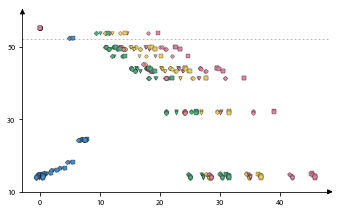

C:\Users\dlutx\AppData\Local\Temp\ipykernel_4348\3980637545.py:86: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "layout" which is no longer supported as of 3.3 and will become an error in 3.6
  fig.savefig('Fig 3A.pdf',layout="constrained")


In [11]:
%matplotlib inline 
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np

# Creating a figure and axes for subplots:
fig, ax = plt.subplots(1,1, figsize=(120/25.4, 80/25.4), sharex=True)

# Setting up scenarios and labels:
limit_Scenario = ['limit1', 'limit2', 'limit4', 'limit6']
GHG_scenario = ['GHG1', 'GHG2', 'GHG3', 'GHG4']

# Defining colors and markers:
markers = {'GHG1': 's', 'GHG2': 'o', 'GHG3': "v", 'GHG4': 'D'}
colors = {'limit1': '#4A8CC3', 'limit2': '#53AC82', 'limit4': '#EDCD5E', 'limit6': '#DF85A4'}

for i in GHG_scenario:
    for j in limit_Scenario:
        sediment_obj = []
        cost_saving_obj = []    
        # Plotting scatter points:
        
        point_x=cost_lp_below_threshold[(i,j)]
        point_y=sediment_out_lp_below_threshold[(i,j)]
            
            
        if i == 'GHG1':
            scatter1 = ax.scatter( np.mean(list(Low_impact_savings[(i, j)].values())),  Low_impact_Sed[(i, j)], s=12, 
                                  edgecolors='black', c=colors[j], linewidths=0.25, zorder=3,
                                  marker=markers[i])
            scatter2 = ax.scatter( np.mean(list(All_savings[(i, j)].values())) , All_Sed[(i, j)], s=12, 
                                  edgecolors='black', c=colors[j], linewidths=0.25, zorder=3,
                                  marker=markers[i])
            scatter3 = ax.scatter(point_x, point_y, s=12, edgecolors='black',c=colors[j],linewidths=0.25,zorder=3,
                                          marker =markers[i])
            scatter4 = ax.scatter(0, Quo_Sed[(i,j)] , s=12, 
                                  edgecolors='black', c=colors[j], linewidths=0.25, zorder=3,
                                  marker=markers[i])

        else:
            
            scatter1 = ax.scatter( np.mean(list(Low_impact_savings[(i, j)].values())),  Low_impact_Sed[(i, j)], s=12, 
                                  edgecolors='black', c=colors[j], linewidths=0.25, zorder=2,
                                  marker=markers[i])
            scatter2 = ax.scatter( np.mean(list(All_savings[(i, j)].values())) , All_Sed[(i, j)], s=12, 
                                  edgecolors='black', c=colors[j], linewidths=0.25, zorder=2,
                                  marker=markers[i])
            scatter3 = ax.scatter(point_x, point_y, s=12, edgecolors='black',c=colors[j],linewidths=0.25,zorder=2,
                                          marker =markers[i])
            scatter4 = ax.scatter(0, Quo_Sed[(i,j)] , s=12, 
                                  edgecolors='black', c=colors[j], linewidths=0.25, zorder=2,
                                  marker=markers[i])

            
# Set y limit
ax.set_ylim(10, 60)

# Set horizontal reference line:
ax.axhline(y=54.8 * 0.95, xmin=0, xmax=1, color='grey', linewidth=0.5, linestyle='--', dashes=(4, 4))

# Set y ticks and labels:
ax.set_yticks([10, 30, 50])
ax.set_yticklabels([10, 30, 50])
# ax.tick_params(axis='y', length=0, labelsize=8, grid_color='grey')
ax.tick_params(labelbottom=True)

# Remove top and right spines; set left and bottom spine colors:
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('black')
ax.spines['bottom'].set_color('black')

# Add arrows on right and top:
ax.annotate('', xy=(1, 0), xycoords='axes fraction', xytext=(1.02, 0),
            arrowprops=dict(arrowstyle="<|-", color='black'))
ax.annotate('', xy=(0, 1), xycoords='axes fraction', xytext=(0, 1.02),
            arrowprops=dict(arrowstyle="<|-", color='black'))

# Customize subplot appearance:
plt.subplots_adjust(left=0.05, bottom=0.1, right=0.95, top=0.9, wspace=0.1, hspace=0.2)

# Display and save the figure:
plt.show()

fig.savefig('Fig 3A.pdf',layout="constrained")


In [53]:
Low_impact_savings[('GHG2','limit4')]

{(65664, 47844): 23.817991650962256,
 (65665, 47845): 23.870547974006854,
 (65666, 47846): 23.84874124255458,
 (65667, 47847): 37.39840730038361,
 (65668, 47848): 37.56761105991882,
 (65669, 47849): 37.48350374220786,
 (65670, 47850): 27.82947018250286,
 (65671, 47851): 27.900384034919966,
 (65672, 47852): 27.86965689862268,
 (65673, 47853): 36.51197028818285,
 (65674, 47854): 36.58503668442279,
 (65675, 47855): 36.54968314475741,
 (65676, 47856): 55.70689431439314,
 (65677, 47857): 55.716198963313104,
 (65678, 47858): 55.71205844792473,
 (65679, 47859): 41.398916643401776,
 (65680, 47860): 41.4831827203094,
 (65681, 47861): 41.441570028638694,
 (65682, 47862): 27.315608778454532,
 (65683, 47863): 27.342085041210908,
 (65684, 47864): 27.327163293683952,
 (65685, 47865): 45.01006022218178,
 (65686, 47866): 45.14084208707732,
 (65687, 47867): 45.07488248079653,
 (65688, 47868): 32.41701816105058,
 (65689, 47869): 32.445766172538924,
 (65690, 47870): 32.4301432095142,
 (65934, 48519): 29.

C:\Users\dlutx\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:138: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
C:\Users\dlutx\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:139: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "layout" which is no longer supported as of 3.3 and will become an error in 3.6
C:\Users\dlutx\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:140: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "layout" which is no longer supported as of 3.3 and will become an error in 3.6


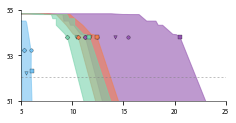

In [12]:
%matplotlib inline
import matplotlib.patches as mpatches


#Creating a figure and axes for subplots:
fig, ax = plt.subplots(1,1,figsize=(80/25.4, 40/25.4),sharex=True)#, gridspec_kw=gs_kw

#Setting up scenarios and labels:
limit_Scenario=['limit1','limit2','limit4','limit6']
GHG_scenario= ['GHG1','GHG2','GHG3','GHG4']

#Defining colors and markers:
markers = {'GHG1':'s','GHG2':'o','GHG3':"v",'GHG4':'D'}
# colors={'limit1':'#78D3AC','limit2':'#4865A9','limit4':'#EF8A43','limit6':'#D9423C'}
colors={'limit1':'#74C1F0','limit2':'#78D3AC','limit4':'#EF7F51','limit6':'#9355B0'}

for i in GHG_scenario:
    for j in limit_Scenario:
        # Collecting data
        sediment_obj = []
        cost_obj = []
        cost_saving_obj = []
        for k in range(49):
            sediment_obj.append(sediment_out_LP[(i,j,k)])
            cost_obj.append(cost_LP[(i,j,k)])
            cost_saving_obj.append(cost_saving[(i,j,k)])
        data_y=sediment_obj
        data_x=cost_saving_obj
        point_x=cost_lp_below_threshold[(i,j)]
        point_y=sediment_out_lp_below_threshold[(i,j)]
            
#         # plotting lines
#         line = ax.plot(data_x, data_y, color=colors[j],linestyle='-',linewidth=1,zorder=1)
        
        # plotting scatter points
        if i=='GHG1':
            scatter1 = ax.scatter(Low_impact_savings[(i,j)], Low_impact_Sed[(i,j)],s=12, edgecolors='black',c=colors[j],linewidths=0.25,zorder=3,
                                          marker =markers[i])
            scatter2 = ax.scatter(All_savings[(i,j)], All_Sed[(i,j)],s=12, edgecolors='black',c=colors[j],linewidths=0.25,zorder=3,
                                          marker =markers[i])
            scatter3 = ax.scatter(point_x, point_y, s=12, edgecolors='black',c=colors[j],linewidths=0.25,zorder=3,
                                          marker =markers[i])
            scatter4 = ax.scatter(0, sediment_out_LP[(i,j,0)],s=12, edgecolors='black',c=colors[j],linewidths=0.25,zorder=3,
                                          marker =markers[i])
        else:
            scatter1 = ax.scatter(Low_impact_savings[(i,j)], Low_impact_Sed[(i,j)],s=12, edgecolors='black',c=colors[j],linewidths=0.25,zorder=2,
                                          marker =markers[i])
            scatter2 = ax.scatter(All_savings[(i,j)], All_Sed[(i,j)],s=12, edgecolors='black',c=colors[j],linewidths=0.25,zorder=2,
                                          marker =markers[i])
            scatter3 = ax.scatter(point_x, point_y, s=12, edgecolors='black',c=colors[j],linewidths=0.25,zorder=2,
                                          marker =markers[i])
            scatter4 = ax.scatter(0, sediment_out_LP[(i,j,0)],s=12, edgecolors='black',c=colors[j],linewidths=0.25,zorder=2,
                                          marker =markers[i])
            
        
# Plot shaded areas for each limit_Scenario
for j in ['limit1','limit6','limit4','limit2']:
    all_sediments = []
    np.array([sediment_out_LP[('GHG1', j, k)] for k in range(49)])
    cost_saving_min = []
    cost_saving_max = []
    for k in range(49):
        if j == 'limit2':
            if  abs(sediment_out_LP[('GHG1', j, k)] - sediment_out_LP[('GHG4', j, k)])<0.1:
                cost_saving_min.append(cost_saving[('GHG4', j, k)])
                cost_saving_max.append(cost_saving[('GHG1', j, k)])
                all_sediments.append(sediment_out_LP[('GHG1', j, k)])
        elif j == 'limit4':
            if  abs(sediment_out_LP[('GHG2', j, k)] - sediment_out_LP[('GHG4', j, k)])<0.1:
                cost_saving_min.append(cost_saving[('GHG4', j, k)])
                cost_saving_max.append(cost_saving[('GHG2', j, k)])
                all_sediments.append(sediment_out_LP[('GHG2', j, k)])          
        elif j == 'limit6':
            if  abs(sediment_out_LP[('GHG1', j, k)] - sediment_out_LP[('GHG4', j, k)])<0.1:
                cost_saving_min.append(cost_saving[('GHG4', j, k)])
                cost_saving_max.append(cost_saving[('GHG1', j, k)])
                all_sediments.append(sediment_out_LP[('GHG1', j, k)])
        else:
            if  abs(sediment_out_LP[('GHG1', j, k)] - sediment_out_LP[('GHG4', j, k)])<0.1:
                cost_saving_min.append(cost_saving[('GHG4', j, k)])
                cost_saving_max.append(cost_saving[('GHG1', j, k)])
                all_sediments.append(sediment_out_LP[('GHG1', j, k)])
            

    y = all_sediments
    x_min = np.array(cost_saving_min)
    x_max = np.array(cost_saving_max)

    ax.fill_betweenx(y, x_min, x_max, color=colors[j],alpha=0.6)









            
        

        
# Set y-axis limit and x-axis limit        
ax.axhline(y=54.8*0.95, xmin=0, xmax=1, color ='grey',linewidth=0.5, linestyle='--',dashes=(4, 4))
ax.set_ylim(51,55)
ax.set_xlim(5,25)

# Set ticks and tick labels of x-axis
ax.set_xticks([5, 10, 15, 20, 25])
ax.set_xticklabels(['5', '10', '15', '20', '25'])
ax.set_yticks([51, 53, 55])
    
# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)  
ax.spines['left'].set_linewidth(0.5)
ax.spines['bottom'].set_linewidth(0.5)

# Set the face and edge color of the figure
# fig.patch.set_facecolor('white')
# fig.patch.set_edgecolor('black')
# fig.patch.set_linewidth(0.5)

# Set the number of tick labels
ax.tick_params(axis='both',  labelsize=7)


# Customizing subplot appearance:
plt.subplots_adjust(left=0.05,
                    bottom=0.1, 
                    right=0.95, 
                    top=0.9, 
                    wspace=0.1, 
                    hspace=0.2)


#Displaying and saving the figure:
fig.show()
fig.savefig('.\Figures\Fig 3\Fig 3A-new-zoom in-2407 .jpg',dpi=1000, layout="constrained")
fig.savefig('.\Figures\Fig 3\Fig 3A-new-zoom in-2407 .pdf',dpi=1000, layout="constrained")